 Logged in successfully


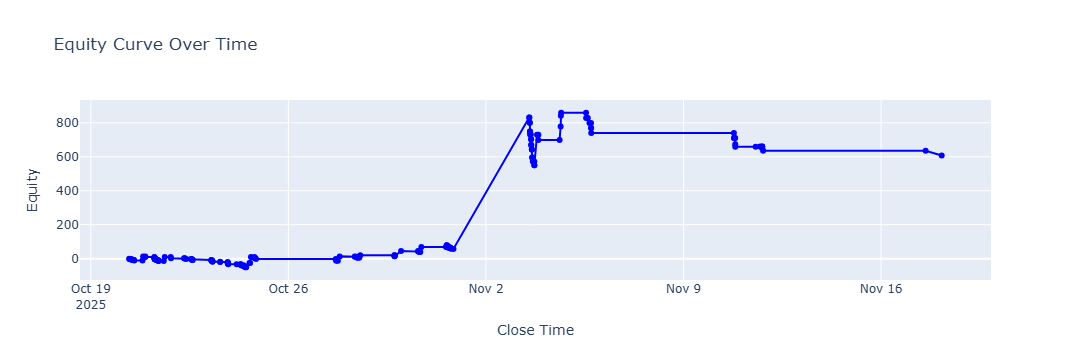

True

In [34]:
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import pandas as pd
import plotly.graph_objects as go

# --- ACCOUNT DETAILS ---
login = 1234567
password = "123456"
server = "123443556"

# --- INITIALIZE MT5 ---
if not mt5.initialize():
    print(" MT5 initialization failed")
    quit()

# --- LOGIN ---
if not mt5.login(login, password=password, server=server):
    print(" Login failed:", mt5.last_error())
    mt5.shutdown()
    quit()
print(" Logged in successfully")

# --- HISTORY RANGE (last 30 days) ---
from_date = datetime.now() - timedelta(days=30)
to_date = datetime.now()

# --- GET CLOSED DEALS ---
deals = mt5.history_deals_get(from_date, to_date)
if deals is None:
    print(" No deals found:", mt5.last_error())
    mt5.shutdown()
    quit()

# --- BUILD DATAFRAME ---
data = []
for d in deals:
    order_info = mt5.history_orders_get(ticket=d.order)
    sl = tp = None
    if order_info and len(order_info) > 0:
        sl = order_info[0].sl
        tp = order_info[0].tp

    deal_type = "BUY" if d.type == 0 else "SELL" if d.type == 1 else str(d.type)

    data.append({
        "Symbol": d.symbol,
        "Type": deal_type,
        "Volume, lot": d.volume,
        "Open price": d.price if d.entry == 0 else None,
        "Close price": d.price if d.entry == 1 else None,
        "T/P": tp,
        "S/L": sl,
        "Position": d.position_id,
        "Open time": datetime.fromtimestamp(d.time_msc/1000) if d.time_msc else datetime.fromtimestamp(d.time),
        "Close time": datetime.fromtimestamp(d.time_msc/1000) if d.time_msc else datetime.fromtimestamp(d.time),
        "Swap, USD": d.swap,
        "Reason": d.reason,
        "P/L, USD": d.profit
    })

df = pd.DataFrame(data)

# --- SORT BY CLOSE TIME ---
df = df.sort_values("Close time").reset_index(drop=True)

# --- CALCULATE EQUITY CURVE ---
df["Equity"] = df["P/L, USD"].cumsum()

# --- PLOT EQUITY CURVE ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df["Close time"],
    y=df["Equity"],
    mode="lines+markers",
    line=dict(color="blue"),
    name="Equity Curve"
))
fig.update_layout(
    title="Equity Curve Over Time",
    xaxis_title="Close Time",
    yaxis_title="Equity"
)
fig.show()

# --- SHUTDOWN MT5 ---
mt5.shutdown()
